In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
import imutils
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import cv2

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5 )

# construct the argument parse and parse the arguments


# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('compare.png' , cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7,7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 75, 225)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = 11.2

# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 10:
        continue

    # compute the rotated bounding box of the contour
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (255, 255, 0), 2)   
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 3, (0, 0, 255), -1)


    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)


    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 8, (255, 0, 0), 1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 8, (255, 0, 0), 1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 8, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 8, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
      (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
      (255, 0, 255), 2)

    # compute the Euclidean distance between the midpoints
    dA = 29.70
    dB = 21.00
    dC = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dD = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB

    # compute the size of the object
    dimA = dA 
    dimB = dB 
    dimC = dC / pixelsPerMetric
    dimD = dD / pixelsPerMetric

    # draw the object sizes on the image
    cv2.putText(orig, "{:.2f} cm ".format(dimA),
      (int(tltrX - 20), int(tltrY - 15)), cv2.FONT_HERSHEY_SIMPLEX,
      0.5, (255, 255, 255), 1)
    cv2.putText(orig, "{:.2f} cm".format(dimB ),
      (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
      0.5, (255, 255, 255), 1)

    cv2.putText(orig, "{:.2f} cm".format(dimC),
      (int(trbrX -70), int(trbrY-225)), cv2.FONT_HERSHEY_SIMPLEX,
      0.7, (125, 255, 255), 1)
    cv2.putText(orig, "{:.2f} cm".format(dimD),
      (int(trbrX ), int(trbrY+30)), cv2.FONT_HERSHEY_SIMPLEX,
      0.7, (12, 255, 255), 1)


    # show the output image
    cv2.imshow("compare.png", orig)
    cv2.waitKey(0)

Original Contour 갯수 554
Convex Hull Contour 갯수 24


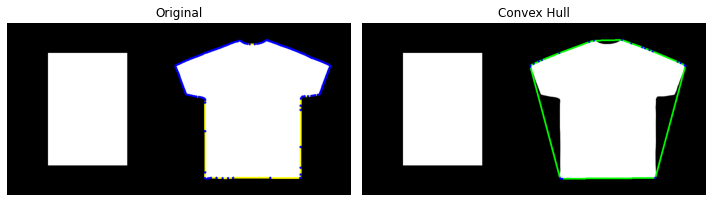

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('compare.png')
img1 = img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
res, thr = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[1]
hull = cv2.convexHull(cnt)
cv2.drawContours(img, [cnt], -1, (255, 255, 0), 3)
cv2.drawContours(img1, [hull], -1, (0, 255, 0), 3)

print('Original Contour 갯수', len(cnt))
print('Convex Hull Contour 갯수', len(hull))

titles = ['Original', 'Convex Hull']
images = [img, img1]
approx = [cnt, hull]

for index in range(2):
    for i in range(len(approx[index])):
        for j in range(len(approx[index][i])):
            cv2.circle(images[index], (approx[index][i][j][0], approx[index][i][j][1]), 3, (0, 0, 255), -1)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
img = cv2.imread('compare.png')
img1 = img.copy()
img2 = img.copy()
img3 = img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
res, thr = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[1]
cv2.drawContours(img, [cnt], -1, (255, 255, 0), 2)

epsilon1 = 0.11 * cv2.arcLength(cnt, True)
epsilon2 =  0.12 * cv2.arcLength(cnt, True)
epsilon3 = 0.13 * cv2.arcLength(cnt, True)

print('Original', cv2.arcLength(cnt, True))
print('epsilon 0.05', epsilon1)
print('epsilon 0.08', epsilon2)
print('epsilon 0.1', epsilon3)
print()

approx1 = cv2.approxPolyDP(cnt, epsilon1, True)
approx2 = cv2.approxPolyDP(cnt, epsilon2, True)
approx3 = cv2.approxPolyDP(cnt, epsilon3, True)

print('Original Contour 갯수', len(cnt))
print('Approx1 Contour 갯수', len(approx1))
print('Approx2 Contour 갯수', len(approx2))
print('Approx3 Contour 갯수', len(approx3))

cv2.drawContours(img1, [approx1], -1, (0, 255, 0), 3)
cv2.drawContours(img2, [approx2], -1, (0, 255, 0), 3)
cv2.drawContours(img3, [approx3], -1, (0, 255, 0), 3)

titles = ['Contours', 'Approx1 (0.05)', 'Approx2 (0.08)', 'Approx2 (0.1)']
images = [img, img1, img2, img3]
approx = [cnt, approx1, approx2, approx3]

for index in range(4):
    for i in range(len(approx[index])):
        for j in range(len(approx[index][i])):
            cv2.circle(images[index], (approx[index][i][j][0], approx[index][i][j][1]), 3, (0, 0, 255), -1)

plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()